# Programming Exercise 2: Logistic Regression

## Introduction
In this exercise, you will implement logistic regression and apply it to two different datasets. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

## 1. Logistic Regression
In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.

Note: The file `data/ex2/ex2data1.txt` and `data/ex2/ex2data2.txt` are both CSV (Comma-separated Value) files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize

%matplotlib inline

### 1.1. Visualizing the data
Before starting to implement any learning algorithm, it is always good to visualize the data if possible. In the first part, the code will load the data and display it on a 2-dimensional plot by calling the function `plotData`.

You will now complete the code in `plotData` so that it displays a figure of the data, where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

In [2]:
# Load data from CSV file
# - column 1: score of first exam
# - column 2: score of second exam
# - column 3: admitted (1) or not (0)
data = np.loadtxt('ex2data1.txt', delimiter=',')

# Split data into X and y
X, y = np.hsplit(data, np.array([2]))

# Print out some data points
print("First 10 examples from the dataset:")
for i in range(10):
    print("x = " + str(X[i, :]) + ", y = " + str(y[i]))

First 10 examples from the dataset:
x = [ 34.62365962  78.02469282], y = [ 0.]
x = [ 30.28671077  43.89499752], y = [ 0.]
x = [ 35.84740877  72.90219803], y = [ 0.]
x = [ 60.18259939  86.3085521 ], y = [ 1.]
x = [ 79.03273605  75.34437644], y = [ 1.]
x = [ 45.08327748  56.31637178], y = [ 0.]
x = [ 61.10666454  96.51142588], y = [ 1.]
x = [ 75.02474557  46.55401354], y = [ 1.]
x = [ 76.0987867   87.42056972], y = [ 1.]
x = [ 84.43281996  43.53339331], y = [ 1.]


In [3]:
def plotData(X, y, x1label='Admitted', x2label='Not admitted'):
    """
    `plotData` plots the data points X and y into a new figure. It will
    plot the data points with + for the positive examples and o for the
    negative examples. X is assumed to be a Mx2 matrix.
    """
    
    # Get the indices of positive and negative examples
    pos = np.squeeze(y == 1)
    neg = np.squeeze(y == 0)
    plt.scatter(X[pos][:, 0], X[pos][:, 1], c='k', marker='+', label=x1label)
    plt.scatter(X[neg][:, 0], X[neg][:, 1], c='y', marker='o', label=x2label)
    plt.title("Scatter plot of training data")
    plt.xlabel("Exam 1 score")
    plt.ylabel("Exam 2 score")
    plt.legend()

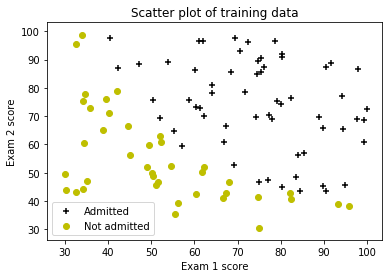

In [4]:
# Visualize the data
plotData(X, y)
plt.show()

### 1.2. Implementation
#### 1.2.1. Warmup exercise: sigmoid function
Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:
$$h_{\theta}(x) = g(\theta ^T x)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:
$$g(z) = \frac{1}{1+e^{-z}}$$

Your first step is to implement `sigmoid` function so it can be called by the rest of your program. When you are finished, try testing a few values by calling `sigmoid(x)`. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**

In [5]:
def sigmoid(z):
    """
    Return sigmoid(x) = 1 / (1 + e^(-z))
    """
    
    return 1 / (1 + np.exp(-z))

In [6]:
# Test sigmoid
print("sigmoid([[-10, 0, 10]]) = " + str(sigmoid(np.array([[-10, 0, 10]]))))

sigmoid([[-10, 0, 10]]) = [[  4.53978687e-05   5.00000000e-01   9.99954602e-01]]


#### 1.2.2 Cost function and gradient
Now you will implement the cost function and gradient for logistic regression. Complete the code in function `costFunction` to return the cost and gradient.

Recall that the cost function in logistic regression is
$$J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)} \log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))]$$
and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{\text{th}}$ element (for $j = 0, 1, \ldots, n$) is defined as follows:
$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_{\theta}(x)$.

Once you have done, the code will call your `costFunction` using the initial parameters of $\theta$. You should see that the cost is about 0.693.

In [7]:
def costFunction(theta, X, y):
    """
    `J, grad = costFunction(X, y, theta)` computes the cost of using theta
    as the parameters for logistic regression and the gradient of the cost
    w.r.t. the parameters.
    """
    
    # Arguments theta and y may be rank 1 array
    theta = theta.reshape((theta.shape[0], 1))
    y = y.reshape((y.shape[0], 1))
    
    # Initialize the number of training examples
    m = X.shape[0]
    
    # Compute the cost J
    J = np.sum(- y * np.log(sigmoid(np.dot(X, theta))) \
               - (1-y) * np.log(1 - sigmoid(np.dot(X, theta)))) / m
    
    # Compute the gradients
    grads = np.dot(X.T, sigmoid(np.dot(X, theta))-y) / m
    # Rerturn J and grads (grads should be a rank 1 array)
    return J, grads.ravel()

In [8]:
# Compute cost and gradient

# Get the number of examples (m) and the number of features (n)
m, n = X.shape
print("The number of training examples: " + str(m))
print("The number of features: " + str(n))

# Add intercept term to X
X = np.hstack((np.ones((m, 1)), X))

# Initialize fitting parameters
initial_theta = np.zeros((n+1, 1))

# Compute and display initial cost and gradient
cost, grad = costFunction(initial_theta, X, y)

print("Cost at initial theta (zeros):")
print(cost)
print("Expected cost (approx): 0.693")
print("Gradeint at initial theta (zeros):")
print(grad[True].T) # turn grad from rank 1 array to column vector
print("Expected gradients (approx):")
print(str(np.array([[-0.1000], [-12.0092], [-11.2628]])))

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([[-24], [0.2], [0.2]])
cost, grad = costFunction(test_theta, X, y)


print("Cost at test theta [[-24] [0.2] [0.2]]:")
print(cost)
print("Expected cost (approx): 0.218")
print("Gradeint at test theta [[-24] [0.2] [0.2]]:")
print(grad[True].T) # turn grad from rank 1 array to column vector
print("Expected gradients (approx):")
print(str(np.array([[0.043], [2.566], [2.647]])))

The number of training examples: 100
The number of features: 2
Cost at initial theta (zeros):
0.69314718056
Expected cost (approx): 0.693
Gradeint at initial theta (zeros):
[[ -0.1       ]
 [-12.00921659]
 [-11.26284221]]
Expected gradients (approx):
[[ -0.1   ]
 [-12.0092]
 [-11.2628]]
Cost at test theta [[-24] [0.2] [0.2]]:
0.218330193827
Expected cost (approx): 0.218
Gradeint at test theta [[-24] [0.2] [0.2]]:
[[ 0.04290299]
 [ 2.56623412]
 [ 2.64679737]]
Expected gradients (approx):
[[ 0.043]
 [ 2.566]
 [ 2.647]]


#### 1.2.3. Learning parameters using optimization functions
In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use scipy built-in function called `optimize.minimize` (corresponding to  `fminunc` in MATLAB/Octave).

`optimize.minimize` is an optimization solver that can find the minimum of your cost function. For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.

Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of $X$ and $y$ values). You will pass to `minimize` the following inputs:
- **x0:** The initial values of the parameters we are trying to optimize.
- **fun:** Objective function (cost function), when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset $(X, y)$. 
- **args:** tuple, optional. Extra arguments passed to the objective function and its derivatives (Jacobian, Hessian).
- **jac:** bool or callable, optional. Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg. If *jac* is a `Boolean` and is `True`, *fun* is assumed to return the gradient along with the objective function. If `False`, the gradient will be estimated numerically. *jac* can also be a callable returning the gradient of the objective. In this case, it must accept the same arguments as *fun*.

And `minimize` will return the optimal parameters of $\theta$, with a cost about 0.203.

This final $\theta$ value will then be used to plot the decision boundary on the training data.

In [9]:
# Optimizing using minimize
# Note: `fminunc` in MATLAB/Octave uses Quasi-Newton method by default,
# so I use *BFGS* (Quasi-Newton's implementation) here.
# https://en.wikipedia.org/wiki/Quasi-Newton_method
optimizeResult = minimize(fun=costFunction, x0=initial_theta.ravel(), \
                          args=(X, y.ravel()), method='BFGS', \
                          jac=True, options={'maxiter':400})
# print(optimizeResult)

theta = optimizeResult.x
theta = theta.reshape((theta.shape[0], 1))
cost = optimizeResult.fun
# Print theta to screen
print("Cost at theta found by minimize: " + str(cost))
print("Expected cost (approx): 0.203")
print("theta: ")
print(theta)
print("Expected theta (approx): ")
print(np.array([[-25.161], [0.206], [0.201]]))

Cost at theta found by minimize: 0.69314718056
Expected cost (approx): 0.203
theta: 
[[ 0.]
 [ 0.]
 [ 0.]]
Expected theta (approx): 
[[-25.161]
 [  0.206]
 [  0.201]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [10]:
def plotDecisionBoundary(theta, X, y, lambd=1):
    """
    Plots the data points X and y into a new figure with the decision
    boundary defined by theta.
    It will plot the data points with + for the positive examples and o
    for the negative examples. X is assumed to be a either
    1) Mx3 matrix, where the first column is an all-ones column for the
    intercept
    2) MxN, N>3 matrix, where the first column is all-ones
    """
    
    # Get the original data of X without the intercept term
    X_orig = np.hsplit(X, np.array([1]))[1]
    
    if X.shape[1] <= 3:
        # Plot the training data
        plotData(X_orig, y)
        # Plot a straight line
        # Only need 2 points to define a line, so choose two endpoints
        x1_min = X_orig.min(axis=0)[0]
        x1_max = X_orig.max(axis=0)[0]
        x1_plot = np.arange(x1_min, x1_max)
        x2_plot = (0 - theta[0] - theta[1] * x1_plot) / theta[2]
        plt.plot(x1_plot, x2_plot)
        plt.axis([30, 100, 30, 100])
    else:
        # Plot the training data
        figContour = plt.figure()
        plotData(X_orig, y, "y=1", "y=0")
        # Plot a contour
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((u.shape[0], v.shape[0]))
        # Evaluate z = theta * x over the grid
        for i in range(u.shape[0]):
            for j in range(v.shape[0]):
                uArray = np.array([[u[i]]])
                vArray = np.array([[v[j]]])
                z[i][j] = np.dot(mapFeature(uArray, vArray), theta)

        
        # Make the meshgrid
        u, v = np.meshgrid(u, v)
                
        z = z.T # important to transpoze z before calling contour
        
        # Contour plot
        plt.contour(u, v, z, np.array([0]))
        plt.xlabel("Microchip Test 1")
        plt.ylabel("Microchip Test 2")
        plt.title(r"Training data with decision boundary ($\lambda$ = " \
                  + str(lambd) + ")")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


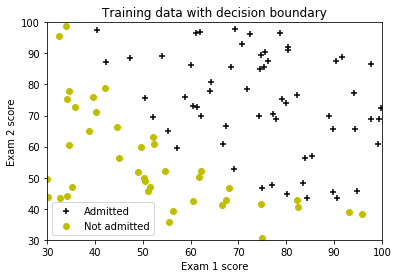

In [11]:
# Plot the decision boundary
plotDecisionBoundary(theta, X, y)
plt.title("Training data with decision boundary")
plt.show()

#### 1.2.4. Evaluating logistic regression
After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission probability of 0.776.

Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code of `predict` function. The `predict` function will produce "1" or "0" predictions given a dataset and a learned parameter vector $\theta$.

After completed `predict` function, the script will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [12]:
# Predict probability for a student with score 45 on exam 1 and score 85
# on exam 2
prob = np.squeeze(sigmoid(np.dot(np.array([[1, 45, 85]]), theta)))
print("For a student with scores 45 and 85, we predict an admission " \
     + "probability of " + str(prob))
print("Expected value: 0.775 +/- 0.002")

For a student with scores 45 and 85, we predict an admission probability of 0.5
Expected value: 0.775 +/- 0.002


In [13]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression
    parameters theta.
    p = predict(theta, X) computes the predictions for X using a threshold
    at 0.5 (i.e., if sigmoid(np.dot(x, theta)) >= 0.5, predict 1)
    """
    
    m = X.shape[0]  # number of training examples
    p = np.zeros((m, 1))
    h = sigmoid(np.dot(X, theta))
    p[h >= 0.5] = 1
    return p

In [14]:
# Compute accuracy on our training set
p = predict(theta, X)
accuracy = np.sum(p == y) / m * 100  # when sum, True as 1, False as 0
print("Train Accuracy: " + str(accuracy))
print("Expected accuracy (approx): 89.0")

Train Accuracy: 60.0
Expected accuracy (approx): 89.0


## 2. Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

### 2.1. Visualizing thet data
Similar to the previous parts of this exercise, `plotData` is used to generate a figure of the data, where the axes are the two test scores and the positive ($y = 1$, accepted) and negative ($y = 0$, rejected) examples
are shown with different markers.

But the data of `data/ex2/ex2data1.txt` cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will only be able to find a linear decision boundary.

In [15]:
# Load data from CSV file
# - column 1: score of microchip test 1
# - column 2: score of microchip test 2
# - column 3: accepted (1) or not (0)
data_reg = np.loadtxt('ex2data2.txt', delimiter=',')

# Split data into X and y
X_reg, y_reg = np.hsplit(data_reg, np.array([2]))

# Print out some data points
print("First 10 examples from the dataset:")
for i in range(10):
    print("x = " + str(X_reg[i, :]) + ", y = " + str(y_reg[i]))
    


First 10 examples from the dataset:
x = [ 0.051267  0.69956 ], y = [ 1.]
x = [-0.092742  0.68494 ], y = [ 1.]
x = [-0.21371  0.69225], y = [ 1.]
x = [-0.375    0.50219], y = [ 1.]
x = [-0.51325  0.46564], y = [ 1.]
x = [-0.52477  0.2098 ], y = [ 1.]
x = [-0.39804   0.034357], y = [ 1.]
x = [-0.30588 -0.19225], y = [ 1.]
x = [ 0.016705 -0.40424 ], y = [ 1.]
x = [ 0.13191 -0.51389], y = [ 1.]


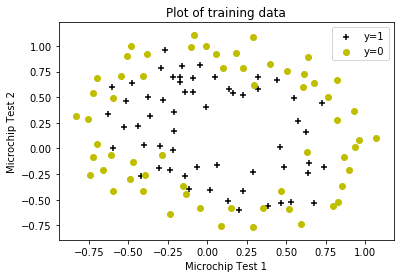

In [16]:
# Visualize the data
plotData(X_reg, y_reg, "y=1", "y=0")
plt.xlabel("Microchip Test 1")
plt.ylabel("Microchip Test 2")
plt.title("Plot of training data")
plt.show()

### 2.2. Feature mapping
One way to fit the data better is to create more features from each data point. In the function `mapFeature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.
$$\text{mapFeature}(x) = \left[\begin{array}{c} 1 \\ x_1 \\ x_2 \\ x_2 \\ x_1^2 \\ x_1 x_2 \\ x_2^2 \\ x_1^3 \\ \vdots \\ x_1 \\ x_2^5 \\ x_2^6 \end{array} \right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help cambat the overfitting problem.

In [17]:
def mapFeature(X1, X2):
    """
    Feature mapping function to polynomial features.
    `mapFeature(X1, X2)` maps the two input features to quadratic features
    used in the regularization exercise.
    Returns a new feature array with more features, comprising of
    X1, X2, X1**2, X2**2, X1*(X2**2), etc.
    The input X1, X2 must be the same size.
    """
    
    degree = 6
    result = np.ones((X1.shape[0], 1))
    for i in range(1, degree+1):
        for j in range(i+1):
            result = np.hstack((result, np.power(X1, i-j) * np.power(X2, j)))
    
    return result

In [18]:
# Note that mapFeature also adds a column of ones, so the intercept
# term is handled
X_reg = mapFeature(X_reg[:, 0][True].T, X_reg[:, 1][True].T)

### 2.3. Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code in `costFunctionReg` function to return the cost and gradient.

Recall that the regularized cost function in logistic regression is
$$ J(\theta) = \frac{1}{m} [-y^{(i)} \log (h_{\theta}(x^{(i)})) - (1-y^{(i)}) \log (1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameter $\theta_0$. The gradient of the cost function is a vector where the $j^\text{th}$ element is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)} \qquad \text{for } j = 0 $$
$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left(\frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)} - y^{(i)}) x_j^{(i)}\right) + \frac{\lambda}{m} \theta_j \qquad \text{for } j \geq 1 $$

Once you are done, the script will call your `costFunctionReg` function using the initial value of $\theta$ (initialized to all zeros). You should see that the cost is about 0.693.

In [19]:
def costFunctionReg(theta, X, y, lambd):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. the parameters.
    """
    
    # Arguments theta must be rank 1 array
    theta = theta.reshape((theta.shape[0], 1))
    
    # Initialize the number of training examples
    m = X.shape[0]
    
    # Compute the cost J
    J = np.sum(- y * np.log(sigmoid(np.dot(X, theta))) \
               - (1-y) * np.log(1 - sigmoid(np.dot(X, theta)))) / m \
        + np.dot(theta[1:].T, theta[1:]) * lambd / (2 * m)
    J = np.squeeze(J)
    
    # Compute the gradients
    grads = np.dot(X.T, sigmoid(np.dot(X, theta))-y) / m + lambd / m * theta
    grads[0] = grads[0] - lambd / m * theta[0]
    # Rerturn J and grads (grads should be a rank 1 array)
    return J, grads.ravel()

In [20]:
# Get the number of examples (m) and the number of features (n)
m, n = X_reg.shape
print("The number of training examples: " + str(m))
print("The number of features: " + str(n))

# Initialize fitting parameters
initial_theta = np.zeros((X_reg.shape[1], 1))
# Set regularization parameter lambd to 1
lambd = 1

# Compute and display initial cost and gradient for regularized logistic
# regression with all-zeros theta and lambd = 1
cost, grad = costFunctionReg(initial_theta, X_reg, y_reg, lambd)

print("Cost at initial theta (zeros): ")
print(cost)
print("Expected cost (approx): 0.693")
print("Gradient at initial theta (zeros) - first five values only:")
print(grad[0:5][True].T)
print("Expected gradients (approx) - first five values only:")
print(np.array([[0.0085], [0.0188], [0.0001], [0.0503], [0.0115]]))

# Set theta to all-ones
test_theta = np.ones((X_reg.shape[1], 1))
# Set regularization parameter lambd to 10
lambd = 10

# Compute and display cost and gradient with all-ones theta and lambd = 10
cost, grad = costFunctionReg(test_theta, X_reg, y_reg, lambd)

print("Cost at test theta (ones) with lambd = 10: ")
print(cost)
print("Expected cost (approx): 3.16")
print("Gradient at test theta (ones) - first five values only:")
print(grad[0:5].reshape((5, 1)))
print("Expected gradients (approx) - first five values only:")
print(np.array([[0.3460], [0.1614], [0.1948], [0.2269], [0.0922]]))

The number of training examples: 118
The number of features: 28
Cost at initial theta (zeros): 
0.6931471805599454
Expected cost (approx): 0.693
Gradient at initial theta (zeros) - first five values only:
[[  8.47457627e-03]
 [  1.87880932e-02]
 [  7.77711864e-05]
 [  5.03446395e-02]
 [  1.15013308e-02]]
Expected gradients (approx) - first five values only:
[[ 0.0085]
 [ 0.0188]
 [ 0.0001]
 [ 0.0503]
 [ 0.0115]]
Cost at test theta (ones) with lambd = 10: 
3.1645093316150095
Expected cost (approx): 3.16
Gradient at test theta (ones) - first five values only:
[[ 0.34604507]
 [ 0.16135192]
 [ 0.19479576]
 [ 0.22686278]
 [ 0.09218568]]
Expected gradients (approx) - first five values only:
[[ 0.346 ]
 [ 0.1614]
 [ 0.1948]
 [ 0.2269]
 [ 0.0922]]


#### 2.3.1. Learning parameters using `minimize`
Similar to the previous parts, you will use `minimize` to learn the optimal parameters $\theta$. If you have completed the cost and gradient for regularized logistic regression (`costFunctionReg`) correctly, you should be able to step through the next part to learn the parameters $\theta$ using `minimize`.

In [21]:
# Initialize fitting parameters
initial_theta = np.zeros((X_reg.shape[1], 1))
# Set regularization parameter lambd to 1
lambd = 1

# Optimizing using minimize
optimizeResult = minimize(fun=costFunctionReg, x0=initial_theta.ravel(), \
                          args=(X_reg, y_reg, lambd), \
                          method='BFGS', jac=True, \
                          options={'maxiter':400})
# print(optimizeResult)

theta = optimizeResult.x
theta = theta.reshape((theta.shape[0], 1))
cost = optimizeResult.fun

# Compute accuracy on our training set
p = predict(theta, X_reg)
accuracy = np.sum(p == y_reg) / m * 100  # when sum, True as 1, False as 0
print("Train Accuracy: " + str(accuracy))
print("Expected accuracy (with lambd = 1) (approx): 83.1")
print(theta)

Train Accuracy: 83.0508474576
Expected accuracy (with lambd = 1) (approx): 83.1
[[ 1.27268739]
 [ 0.62557016]
 [ 1.1809665 ]
 [-2.01919822]
 [-0.91761468]
 [-1.43194199]
 [ 0.12375921]
 [-0.36513086]
 [-0.35703388]
 [-0.17485805]
 [-1.45843772]
 [-0.05129676]
 [-0.61603963]
 [-0.2746414 ]
 [-1.19282569]
 [-0.24270336]
 [-0.20570022]
 [-0.04499768]
 [-0.27782709]
 [-0.29525851]
 [-0.45613294]
 [-1.04377851]
 [ 0.02762813]
 [-0.29265642]
 [ 0.01543393]
 [-0.32759318]
 [-0.14389199]
 [-0.92460119]]


### 2.4. Plotting the decision boundary
To help you visualize the model learned by this classifier, `plotDecisionBoundary` will plot the decision boundary that separates the positive and negative examples. In `plotDecisionBoundary`, we plot the non-linear decision boundary by computing the classifier's predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from $y = 0$ to $y = 1$.

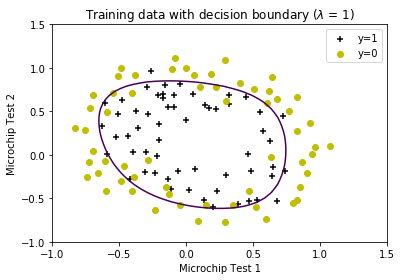

In [22]:
plotDecisionBoundary(theta, X_reg, y_reg)
plt.show()

### 2.5. Try out different regularization parameters
In this part of the exercise, you will get to try different regularization parameters for the dataset to understand how regularization prevents overfitting.

Notice the changes in the decision boundary as you vary $\lambda$. With a small $\lambda$, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, it predicts that a point at $x = (-0.25, 1.5)$ is accepted ($y = 1$), which seems to be an incorrect decision given the training set.

With a larger $\lambda$, you should see a plot that shows an simpler decision boundary which still separates the positive and negative fairly well. However, if $\lambda$ is set too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

In [23]:
def model(X, y, lambd, initial_theta):
    # Optimizing using minimize
    optimizeResult = minimize(fun=costFunctionReg, x0=initial_theta.ravel(), \
                              args=(X, y, lambd), \
                              method='BFGS', jac=True, \
                              options={'maxiter':400})
    theta = optimizeResult.x
    theta = theta.reshape((theta.shape[0], 1))
    
    return theta

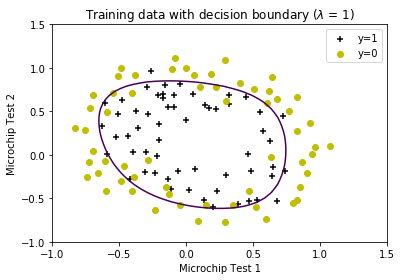

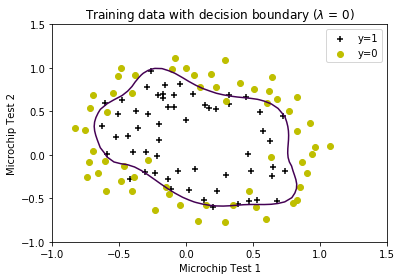

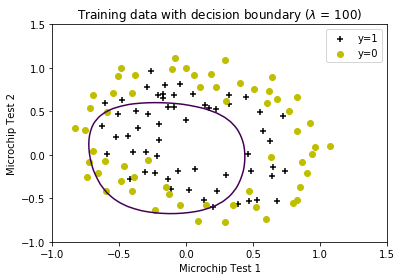

In [24]:
# Initialize fitting parameters
initial_theta = np.zeros((X_reg.shape[1], 1))
# Set regularization parameter lambd to 1
lambdArray = [1, 0, 100]

for lambd in lambdArray:
    theta = model(X_reg, y_reg, lambd, initial_theta)
    plotDecisionBoundary(theta, X_reg, y_reg, lambd)
    plt.show()